# Pratiques d'écoutes musicales et omnivorisme culturel
Projet *Python pour la Data Science* de _Ribeiro Morgane_ et _Ley Juline_

### INTRODUCTION

Ce notebook sert de rendu final de projet Python. Il explore la notion d'omnivorisme culturel. 

### SOMMAIRE 
* [Installation](#Install)

* [Préparation des données](#prepa)

* [Statistiques descriptives](#statdesc)

* [Analyse](#analyse)


## Installation <a class="anchor" id="Install"></a>



In [1]:
!pip install -r requirements.txt --quiet

#Importations
import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm
import geopandas as gpd
import matplotlib.pyplot as plt

import os
import seaborn as sns
from prince import MCA
from sklearn.cluster import KMeans
from plotnine import *
from scipy.stats import spearmanr
from scipy.stats import pearsonr

#Fonctions
from scripts import fonctions


## Préparation des données <a class="anchor" id="prepa"></a>

Les données utilisées sont également disponibles ici : 

Pratiques d'écoute de musique en ligne - 2020 : https://www.data.gouv.fr/datasets/pratiques-decoute-de-musique-en-ligne-2020 

Consommation des contenus culturels et sportifs numériques - Baromètre : https://www.data.gouv.fr/datasets/consommation-des-contenus-culturels-et-sportifs-numeriques-barometre


### 1. Adresses 

In [2]:
url_barometre = "https://www.data.gouv.fr/api/1/datasets/r/aff9d702-db6d-46e5-8416-c032d8b9d89d"

url_musique = "https://www.data.gouv.fr/api/1/datasets/r/85d1feb0-76cc-4e84-96f4-169971db952e"


### 2. Chargement des données

In [3]:
fonctions.telecharger(url_barometre, "data_barometre.xlsx", "/home/onyxia/work/Projet_Python_pour_DS/data")
fonctions.telecharger(url_musique, "data_musique.xlsx", "/home/onyxia/work/Projet_Python_pour_DS/data")

df_barometre_brut = pd.read_excel("/home/onyxia/work/Projet_Python_pour_DS/data/data_barometre.xlsx")
df_musique_brut = pd.read_excel("/home/onyxia/work/Projet_Python_pour_DS/data/data_musique.xlsx")


Téléchargement réussi !
Téléchargement réussi !


### 3. Structure de la base de données - Baromètre


In [4]:
fonctions.analyser(df_barometre_brut)


La base de données contient 5002 observations et 831 variables. 
Elle comprend 180 variables numériques, 651 variables de type texte, 
On observe 3185977 valeurs manquantes, soit 76.65% de l’ensemble des cellules, 
réparties sur 736 variables. 
Enfin, 175 variables sont constantes. 
 


### 3. Structure de la base de données - Pratique d'écoute de musique en ligne

In [5]:
fonctions.analyser(df_musique_brut)


La base de données contient 2200 observations et 261 variables. 
Elle comprend 1 variables numériques, 260 variables de type texte, 
On observe 214 valeurs manquantes, soit 0.04% de l’ensemble des cellules, 
réparties sur 1 variables. 
Enfin, 2 variables sont constantes. 
 


On se rend compte en ouvrant la base de données que la part de valeurs manquantes est bien plus élevée que 0.04%. Un recodage de deux bases de données est donc nécessaire

### 4. Recodage des données - Baromètre

Le recodage va également nous permettre de trier les variables qui nous intéressent. La base de données se concentrant très précisément sur le caractère légal ou non des activités des répondants, notre sélection a priorisé les éléments sociodémographiques des répondants, ainsi que les pratiques culturelles de ces derniers.

Par souci de lisibilité du notebook, nous avons décidé de mettre le recodage final dans une fonction (disponible dans ```/home/onyxia/work/Projet_Python_pour_DS/scripts/fonctions.py```) il ne s'agit pas réellement d'une fonction à proprement parler, puisqu'elle n'est qu'utilisable pour une liste précise de variables et un DataFrame précis.

La réponse aux questions est séparée en plusieurs variables (chacune correspondantes à une réponse : par exemple, pour la question Q1 "quel produit avez-vous consommé de manière dématérialisée ces 12 derniers mois ? Plusieurs réponses sont possibles", la variable ```Q1_1``` est uniquement remplie lorsque le répondant consomme de la musique, ```Q1_2```, uniquement remplie lorsque le répondant consomme des films, etc.), un recodage en variable binaire a été nécessaire.

Un autre recodage consistait à créer des "échelles" d'intensité, de diversité de pratiques ou de fréquences afin de réaliser les statistiques descriptives. 

In [29]:
variables_barometre = [
    "SEXE", "AGE", "AGGLOIFOP2", "TYPCOM", "TAILCOM", "DPT", "REG3", "REG13", "PI4",
    "SITI", "PPIA", "RECPPIA", "STCA", "STATUT", "FOYER", "POIDS",
    #Q1 quel produit avez-vous consommé de manière dématérialisée ces 12 derniers mois ?
    "Q1_1", "Q1_2", "Q1_3", "Q1_4", "Q1_5", "Q1_6", "Q1_7", "Q1_8", "Q1_9", "Q1_10", "Q1_11", 
    #Q2 : à quelle fréquence ?
    "Q2_r1", "Q2_r2", "Q2_r3", "Q2_r4", "Q2_r5", "Q2_r6", "Q2_r7", "Q2_r8", "Q2_r9", "Q2_r10", "Q2_r11", 
    #Q2BIS : regardez-vous des vidéos de courtes durée proposées par Youtube?
    "Q2BIS",
    #Q3 : consommation légale ? (globalité)
    "Q3",
    #Q4 : consommation légale ? globalité dans le cadre des activités proposées question1
    "Q4",
    #Q5_r : consommation légale pour chaque activité
    "Q5_r1", "Q5_r2", "Q5_r3", "Q5_r4", "Q5_r5", "Q5_r6", "Q5_r7", "Q5_r8", "Q5_r9", "Q5_r10", "Q5_r11", 
    #Q6 : fréquence de conso illégale
    "Q6_r1", "Q6_r2", "Q6_r3", "Q6_r4", "Q6_r5", "Q6_r6", "Q6_r7", "Q6_r8", "Q6_r9", "Q6_r10", "Q6_r11", 
    #QBOL14 : comment découvrez-vous de nouveaux films ?
    "QBOL14_1", "QBOL14_2", "QBOL14_3", "QBOL14_4", "QBOL14_5", "QBOL14_6", "QBOL14_7", "QBOL14_8", "QBOL14_9", 
    #QBU1 : consommation payante ou gratuite ?
    "QBU1_r1", "QBU1_r2", "QBU1_r3", "QBU1_r4", "QBU1_r5", "QBU1_r6", "QBU1_r7", "QBU1_r8", "QBU1_r9", "QBU1_r10", "QBU1_r11", 
    #QBU7 : 3 principales raisons de ne pas consommer légalement
    "QBU7_r1_c1", "QBU7_r2_c1", "QBU7_r3_c1", "QBU7_r4_c1", "QBU7_r5_c1", "QBU7_r6_c1", "QBU7_r7_c1", "QBU7_r8_c1", "QBU7_r9_c1", "QBU7_r10_c1", "QBU7_r11_c1", "QBU7_r12_c1", "QBU7_r13_c1", "QBU7_r14_c1", "QBU7_r15_c1", "QBU7_r16_c1", 
    #RS14 : quel service avez vous accès pour écouter de la musique
    "RS14_1", "RS14_2", "RS14_3", "RS14_4", "RS14_5", "RS14_6", "RS14_7", "RS14_8", "RS14_9"
]

pratiques = ["mus","films","series","photos","jv","livres","logi","presse","retrans"]

df_barometre_recode = fonctions.recodage_barometre(df_barometre_brut, variables_barometre)

fonctions.analyser(df_barometre_recode)


/home/onyxia/work/Projet_Python_pour_DS/scripts/fonctions.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/onyxia/work/Projet_Python_pour_DS/scripts/fonctions.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/home/onyxia/work/Projet_Python_pour_DS/scripts/fonctions.py:158: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.



La base de données contient 5002 observations et 47 variables. 
Elle comprend 30 variables numériques, 17 variables de type texte, 
On observe 32206 valeurs manquantes, soit 13.7% de l’ensemble des cellules, 
réparties sur 12 variables. 
Enfin, 0 variables sont constantes. 
 


### 4. Recodage des données - Pratique d'écoute de musique en ligne

Les remarques faites pour le baromètre sont aussi valables pour la base de données de pratique d'écoute de musique en ligne. 

In [7]:
variables_musique = [
    "QSEXE", "RAGE2", "AGGLOIFOP2", "REG3", "REG13", "PI4", "poids", #variables sociodémo
    #A quelle fréquence utilisez-vous Internet ou des applications
    "QRS1",
    # Parmi les produits ou services culturels suivants, le(s)quel(s) avez-vous déjà personnellement consommé(s) de façon dématérialisée sur Internet , au cours des 12 derniers mois ?
    "Q1_1","Q1_2","Q1_3","Q1_4","Q1_5","Q1_6","Q1_7","Q1_8","Q1_9",
    #fréquence consommation musique / videoclip
    "Q3",
    #durée consommation musique/jour
    "Q4",
    #préférences genres musicaux
    "Q5_1", "Q5_2", "Q5_3", "Q5_4", "Q5_5", "Q5_6", "Q5_7", "Q5_8", "Q5_9", "Q5_10", "Q5_11", "Q5_12", 
    #fréquences modes d'accès 
    "Q6_r1", "Q6_r2", "Q6_r3", "Q6_r4", "Q6_r5", "Q6_r6", "Q6_r7", 
    #concerts/festivals au cours des 12 derniers mois
    "Q7",
    #appareils pour écouter musique
    "Q16_1", "Q16_2", "Q16_3", "Q16_4", "Q16_5", "Q16_6", "Q16_7", "Q16_8", "Q16_9", "Q16_10", "Q16_11", 
    #appareil le plus utilisé
    "Q17",
    #écoute moments dans la journée 
    "Q18_1", "Q18_2", "Q18_3", "Q18_4", "Q18_5", "Q18_6", "Q18_7", "Q18_8"
]

pratiques = ["mus","films","series","photos","jv","livres","logi","presse","retrans"]
mode_acces_musique = ["internet", "applications", "CD", "vinyles", "concert", "tele", "radio"]
appareils = ["ordi", "smartphone", "tablette", "tele", "console", "enceinte_intel", "enceinte_classique", "hi_fi", "autoradio", "radio", "platine"]
moments = ["reveil/dormir", "preparation", "chemin", "activités", "voiture", "travail_etude", "cuisine_menage", "amis"]
genres = ["var_fr", "poprock", "rap", "classique", "jazz", "dance", "electro", "metal", "rnb", "soul", "reggae", "musique_monde"]

df_musique_recode = fonctions.recodage_musique(df_musique_brut, variables_musique)

fonctions.analyser(df_musique_recode)



La base de données contient 2200 observations et 71 variables. 
Elle comprend 62 variables numériques, 9 variables de type texte, 
On observe 2421 valeurs manquantes, soit 1.55% de l’ensemble des cellules, 
réparties sur 6 variables. 
Enfin, 0 variables sont constantes. 
 


/home/onyxia/work/Projet_Python_pour_DS/scripts/fonctions.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/onyxia/work/Projet_Python_pour_DS/scripts/fonctions.py:219: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/home/onyxia/work/Projet_Python_pour_DS/scripts/fonctions.py:271: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/home/onyxia/work/Projet_Python_pour_DS/scripts/fonctions.py:318: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


#### Capturer l'omnivorisme musical

Pour capturer l'omnivorisme musical, on peut essayer de récapituler les informations contenues dans plusieurs variables en une seule

Critères pour omnivorisme musical :

- Diversité dans les genres écoutés 
- Fréquence minimale
- Différents moments dans la journée
- Plusieurs types de manière d'écouter

In [33]:

n = 3 #seuil de diversité 
df_musique_recode["nb_genre"] = df_musique_recode[genres].sum(axis=1)
df_musique_recode["diversite_genre"] = (df_musique_recode[genres].sum(axis=1) >= n).astype(int)

df_musique_recode["plusieurs_moments"] = df_musique_recode[moments].sum(axis=1)

df_musique_recode["plusieurs_appareils"] = df_musique_recode[appareils].sum(axis=1)

df_musique_recode["plusieurs_appareils"].describe()

count    2200.000000
mean        2.787727
std         2.071468
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        11.000000
Name: plusieurs_appareils, dtype: float64

## Statistiques descriptives <a class="anchor" id="statdesc"></a>
### Baromètre

Une variable intéressante dans les deux bases de données que nous utilisons est "poids" qui est la pondération de chaque répondant.

In [9]:
print("\n--- Fréquences pondérées des pratiques ---")
for p in pratiques:
    print(f"\n{p}")
    print(fonctions.ponderation_freq(df_barometre_recode[f"conso_demat_{p}"], df_barometre_recode["poids"]))


--- Fréquences pondérées des pratiques ---

mus
conso_demat_mus
0    50.000002
1    49.999998
Name: conso_demat_mus, dtype: float64

films
conso_demat_films
0    49.000005
1    50.999995
Name: conso_demat_films, dtype: float64

series
conso_demat_series
0    54.000002
1    45.999998
Name: conso_demat_series, dtype: float64

photos
conso_demat_photos
0    62.000003
1    37.999997
Name: conso_demat_photos, dtype: float64

jv
conso_demat_jv
0    64.000001
1    35.999999
Name: conso_demat_jv, dtype: float64

livres
conso_demat_livres
0    75.000001
1    24.999999
Name: conso_demat_livres, dtype: float64

logi
conso_demat_logi
0    75.000001
1    24.999999
Name: conso_demat_logi, dtype: float64

presse
conso_demat_presse
0    65.0
1    35.0
Name: conso_demat_presse, dtype: float64

retrans
conso_demat_retrans
0    83.0
1    17.0
Name: conso_demat_retrans, dtype: float64


Femme : 1 / Homme : 0

Consomme de la musique de manière dématérialisée : 1 / ne consomme pas : 0

In [10]:
# Tableaux croisés pondérés (ex : sexe × musique)
ct = pd.pivot_table(
    df_barometre_recode,
    values="poids",
    index="sexe",
    columns="conso_demat_mus",
    aggfunc="sum",
)/5002 * 100

print("\nTableau croisé pondéré sexe × musique (%)")
print(ct)

print("La pratique d'écoute musicale est distribuée équitablement entre les hommes et les femmes")

tableau_csp_musique = pd.pivot_table(
    df_barometre_recode,
    values="poids",
    index="csp",
    columns="conso_demat_mus",
    aggfunc="sum",
)/5002 * 100

print("\nTableau croisé pondéré csp × musique (%)")
print(tableau_csp_musique)
print("La classe socioprofessionnelle écoutant le plus de musique dématérialisée est celle des élèves, étudiant.e.s \ncelle qui en écoute le moins est celle des retraité.e.s")

tableau_legalité_csp = pd.pivot_table(
    df_barometre_recode,
    values="poids",
    index="csp",
    columns="conso_legale",
    aggfunc="sum",
)/5002 * 100

print("\nTableau croisé pondéré csp × culture (%)")
print(tableau_legalité_csp)
print("La classe socioprofessionnelle consommant le plus légalement est celle des employés")


Tableau croisé pondéré sexe × musique (%)
conso_demat_mus          0          1
sexe                                 
0                23.299399  25.700605
1                26.700603  24.299393
La pratique d'écoute musicale est distribuée équitablement entre les hommes et les femmes

Tableau croisé pondéré csp × musique (%)
conso_demat_mus                 0         1
csp                                        
Agriculteurs1            0.672073  0.327927
Artisans1                1.757224  2.242776
Autres1                  4.118478  2.642567
Cadres1                  3.649523  6.350476
ElevesEtudiantsPemploi   2.853871  8.385084
Employes1                8.298582  8.701418
Intermediaires1          6.431422  7.568578
Ouvriers1                6.294842  6.705158
RetraitesCSPMoins        5.617540  2.091493
RetraitesCSPPlus        10.306447  4.984520
La classe socioprofessionnelle écoutant le plus de musique dématérialisée est celle des élèves, étudiant.e.s 
celle qui en écoute le moins est ce

Lors du recodage, nous avons créé plusieurs variables donnant une échelle d'intensité de pratique. L'une d'entre elle est ```indice_legalite``` qui donne une note de légalité aux répondants dans {0, 1, 2, 3, 4} : 4 étant une consommation exclusivement légale, 2 une consommation aussi légale qu'illégale et 0 une consommation purement illégale.

/tmp/ipykernel_10664/2672603214.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


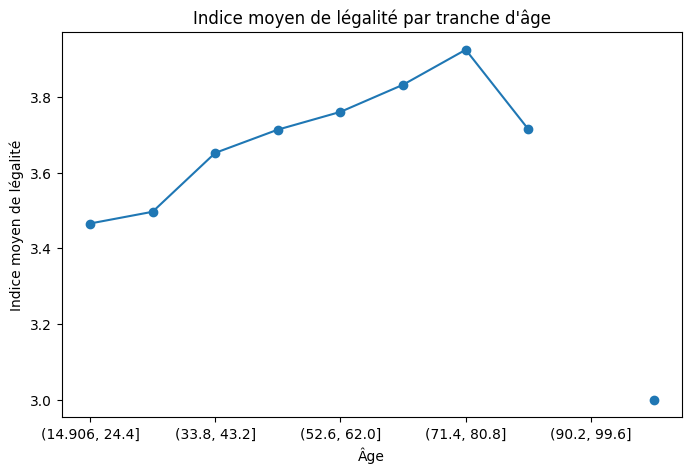

La consommation de produits culturels est majoritairement légale pour des tranches d'âges plus élevés
La moyenne globale de l'indice de l'égalité est de 3.6482680934947904 ce qui est une moyenne très haute. 
Les individus consomment globalement du contenu légalement.


In [54]:
df_plot = (
    df_barometre_recode
    .dropna(subset=["age", "indice_legalite"])
    .sort_values("age")
)

df_plot["age_bin"] = pd.cut(df_plot["age"], bins=10)

df_mean = df_plot.groupby("age_bin")["indice_legalite"].mean()



df_mean.plot(figsize=(8, 5), marker="o")

plt.xlabel("Âge")
plt.ylabel("Indice moyen de légalité")
plt.title("Indice moyen de légalité par tranche d'âge")
plt.show()

print("La consommation de produits culturels est majoritairement légale pour des tranches d'âges plus élevés")
moyenne_indice_legal = df_barometre_recode["indice_legalite"].mean()

print(f"La moyenne globale de l'indice de l'égalité est de {moyenne_indice_legal} ce qui est une moyenne très haute. \nLes individus consomment globalement du contenu légalement.")

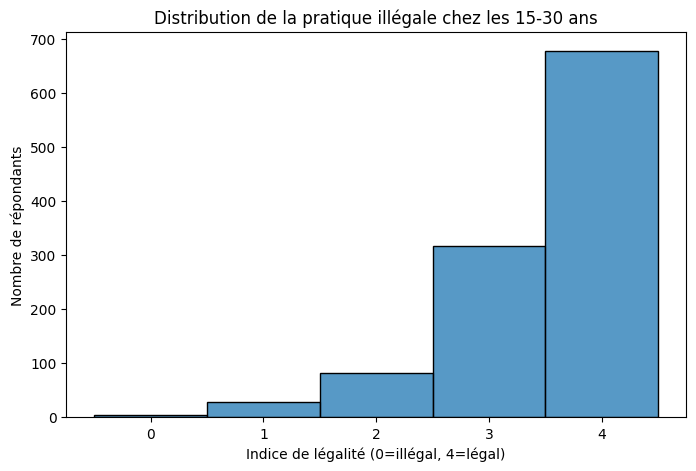

In [55]:
df_15_24 = df_barometre_recode[(df_barometre_recode["age"] >= 15) & (df_barometre_recode["age"] <= 30)]

plt.figure(figsize=(8, 5))
sns.histplot(df_15_24["indice_legalite"], bins=5, discrete=True, kde=False)
plt.xlabel("Indice de légalité (0=illégal, 4=légal)")
plt.ylabel("Nombre de répondants")
plt.title("Distribution de la pratique illégale chez les 15-30 ans")
plt.show()

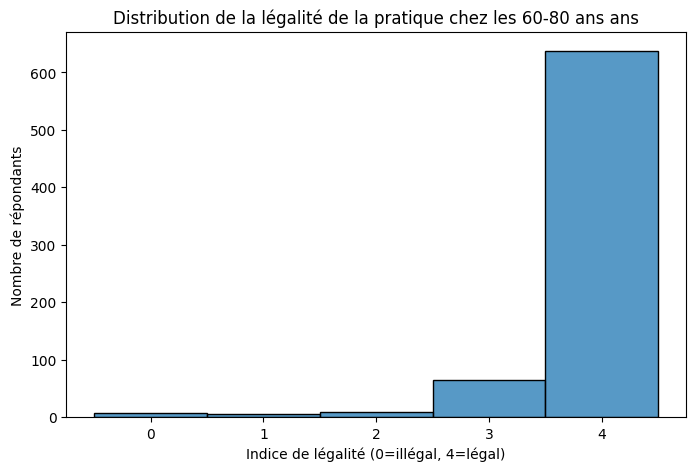

In [56]:
df_70_80 = df_barometre_recode[(df_barometre_recode["age"] >= 60) & (df_barometre_recode["age"] <= 80)]

plt.figure(figsize=(8, 5))
sns.histplot(df_70_80["indice_legalite"], bins=5, discrete=True, kde=False)
plt.xlabel("Indice de légalité (0=illégal, 4=légal)")
plt.ylabel("Nombre de répondants")
plt.title("Distribution de la légalité de la pratique chez les 60-80 ans ans")
plt.show()

### Pratique d'écoute de musique en ligne



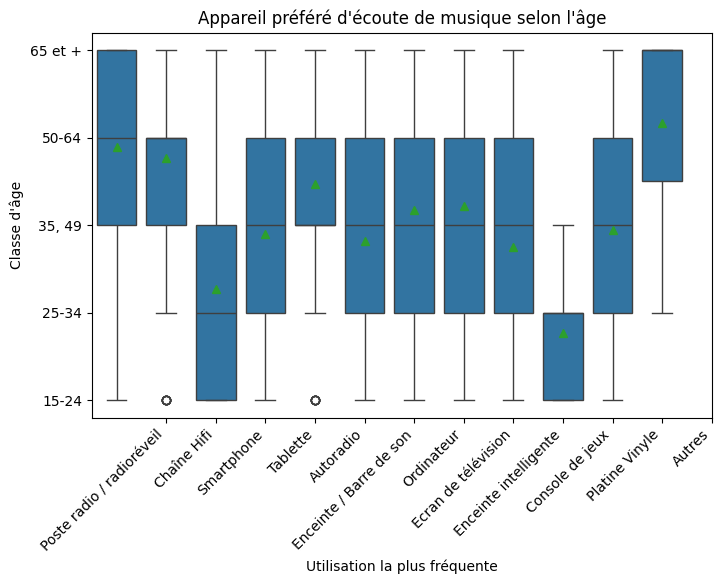

Les individus des tranches d’âge supérieures ont tendance à utiliser des appareils plus traditionnels, tels qu’un poste radio ou une chaîne Hi-Fi, 
tandis que les plus jeunes privilégient les technologies récentes, comme le smartphone ou la console de jeux.


In [53]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_musique_recode,
    x="utilisation_max",
    y="ages_echelle",
    showmeans=True
)

plt.xlabel("Utilisation la plus fréquente")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ["Poste radio / radioréveil", "Chaîne Hifi", "Smartphone", "Tablette", "Autoradio", "Enceinte / Barre de son", "Ordinateur", "Ecran de télévision", "Enceinte intelligente", "Console de jeux", "Platine Vinyle", "Autres"])
plt.ylabel("Classe d'âge")
plt.yticks([1, 2, 3, 4, 5], ["15-24", "25-34", "35, 49", "50-64", "65 et +"])
plt.title("Appareil préféré d'écoute de musique selon l'âge")
plt.xticks(rotation=45, ha='right')  # 45° ou 30° selon la lisibilité

plt.show()

print("Les individus des tranches d’âge supérieures ont tendance à utiliser des appareils plus traditionnels, tels qu’un poste radio ou une chaîne Hi-Fi, \ntandis que les plus jeunes privilégient les technologies récentes, comme le smartphone ou la console de jeux.")

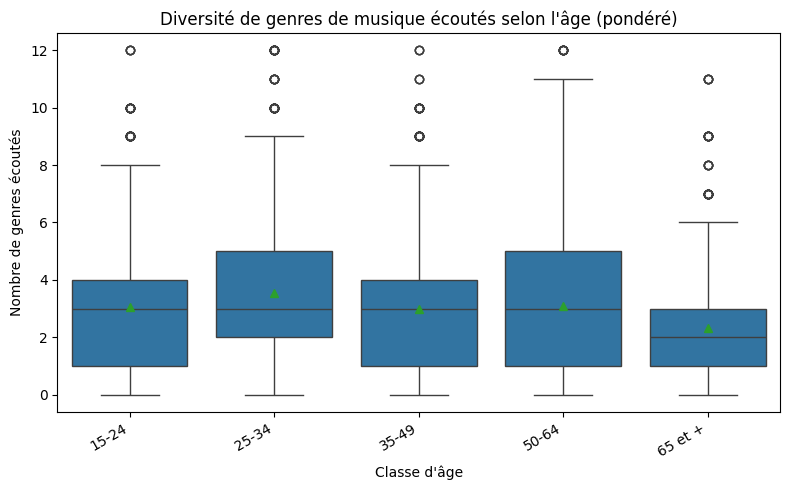

La diversité d'écoute a tendance à très légèrement baisser avec l'âge, 
bien qu'on remarque que la tranche 50-64 ans contient plus d'individus ayant une grande diversité d'écoute.
Coefficient de corrélation de Pearson : -0.116
p-value : 4.734e-08


In [14]:
df_boxplot = df_musique_recode[df_musique_recode["poids"] > 0].copy()
df_boxplot = df_boxplot.reset_index(drop=True)

df_boxplot["poids_norm"] = np.ceil(df_boxplot["poids"] / df_boxplot["poids"].max() * 10)

df_boxplot = df_boxplot.loc[df_boxplot.index.repeat(df_boxplot["poids_norm"])]

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_boxplot,
    x="ages_echelle",
    y="nb_genre",
    showmeans=True
)

plt.ylabel("Nombre de genres écoutés")
plt.xlabel("Classe d'âge")
plt.xticks([0, 1, 2, 3, 4], ["15-24", "25-34", "35-49", "50-64", "65 et +"])
plt.title("Diversité de genres de musique écoutés selon l'âge (pondéré)")

# Rotation ou ajustement si les labels se chevauchent
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

print("La diversité d'écoute a tendance à très légèrement baisser avec l'âge, \nbien qu'on remarque que la tranche 50-64 ans contient plus d'individus ayant une grande diversité d'écoute.")

df_test = df_musique_recode.dropna(subset=["ages_echelle", "nb_genre"])

# Test de corrélation de Pearson
corr, p_value = pearsonr(df_test["ages_echelle"], df_test["nb_genre"])

print(f"Coefficient de corrélation de Pearson : {corr:.3f}")
print(f"p-value : {p_value:.3e}")

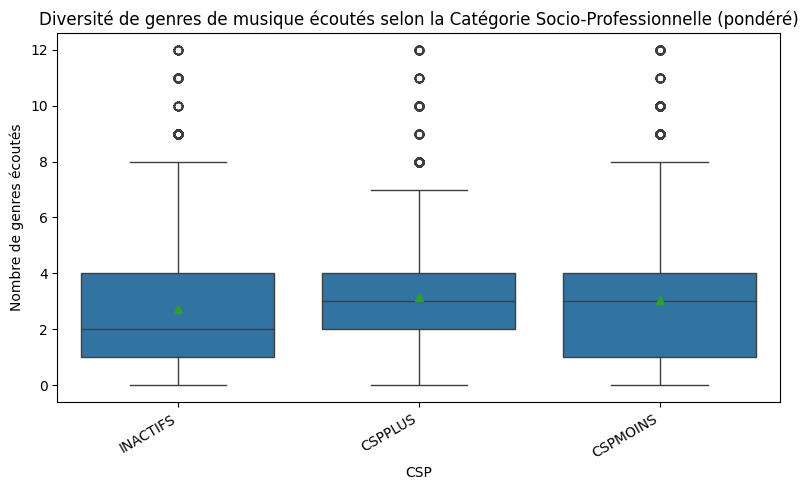

On remarque une moyenne légèrement plus haute pour les CSP+


In [15]:
pdf_boxplot = df_musique_recode[df_musique_recode["poids"] > 0].copy()
df_boxplot = df_boxplot.reset_index(drop=True)

df_boxplot["poids_norm"] = np.ceil(df_boxplot["poids"] / df_boxplot["poids"].max() * 10)

df_boxplot = df_boxplot.loc[df_boxplot.index.repeat(df_boxplot["poids_norm"])]

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_boxplot,
    x="csp",
    y="nb_genre",
    showmeans=True
)

plt.ylabel("Nombre de genres écoutés")
plt.xlabel("CSP")
plt.title("Diversité de genres de musique écoutés selon la Catégorie Socio-Professionnelle (pondéré)")

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()
print("On remarque une moyenne légèrement plus haute pour les CSP+")


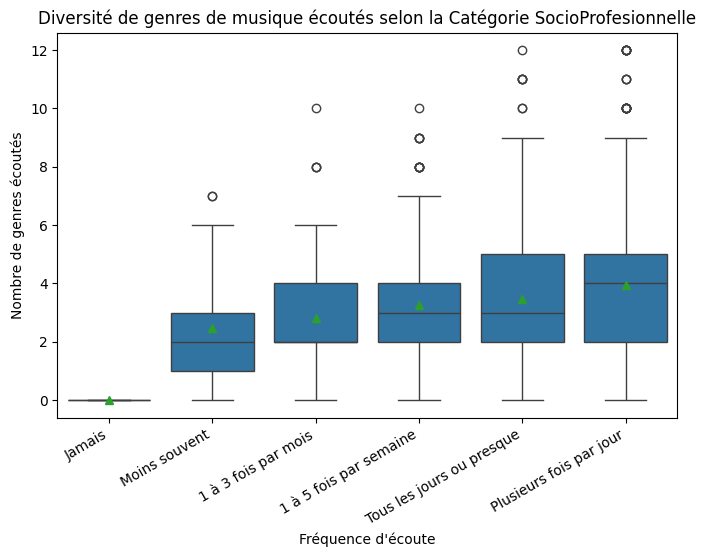

Une corrélation positive entre la fréquence d'écoute de musique et la diversité d'écoute est observée.
Coefficient de corrélation de Pearson : 0.443
p-value : 3.520e-106


In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_musique_recode,
    x="freq_ecoute",
    y="nb_genre",
    showmeans=True
)

plt.ylabel("Nombre de genres écoutés")
plt.xlabel("Fréquence d'écoute")
plt.xticks([0, 1, 2, 3, 4, 5],
           ["Jamais", "Moins souvent", "1 à 3 fois par mois", "1 à 5 fois par semaine",
            "Tous les jours ou presque", "Plusieurs fois par jour"])
plt.title("Diversité de genres de musique écoutés selon la Catégorie SocioProfesionnelle")
plt.xticks(rotation=30, ha='right')  # 45° ou 30° selon la lisibilité

plt.show()

print("Une corrélation positive entre la fréquence d'écoute de musique et la diversité d'écoute est observée.")

df_test = df_musique_recode.dropna(subset=["freq_ecoute", "nb_genre"])

# Test de corrélation de Pearson
corr, p_value = pearsonr(df_test["freq_ecoute"], df_test["nb_genre"])

print(f"Coefficient de corrélation de Pearson : {corr:.3f}")
print(f"p-value : {p_value:.3e}")

Corrélation entre omnivorisme musical et omnivorisme culturel ?

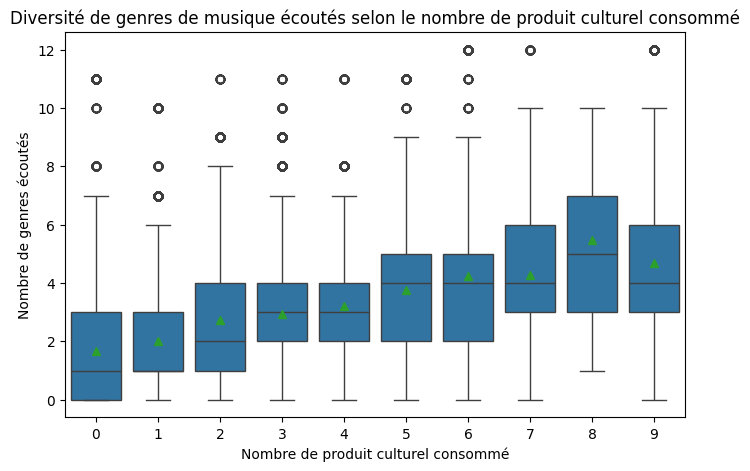

Une corrélation positive est observée entre la diversité de genres de musique écoutés et le nombre de produit culturel consommé.
Coefficient de corrélation de Pearson : 0.437
p-value : 0.000e+00


In [17]:
pdf_boxplot = df_musique_recode[df_musique_recode["poids"] > 0].copy()
df_boxplot = df_boxplot.reset_index(drop=True)

df_boxplot["poids_norm"] = np.ceil(df_boxplot["poids"] / df_boxplot["poids"].max() * 10)

df_boxplot = df_boxplot.loc[df_boxplot.index.repeat(df_boxplot["poids_norm"])]

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_boxplot,
    x="diversite",
    y="nb_genre",
    showmeans=True
)

plt.ylabel("Nombre de genres écoutés")
plt.xlabel("Nombre de produit culturel consommé")

plt.title("Diversité de genres de musique écoutés selon le nombre de produit culturel consommé")

plt.show()

print("Une corrélation positive est observée entre la diversité de genres de musique écoutés et le nombre de produit culturel consommé.")

df_test = df_boxplot.dropna(subset=["diversite", "nb_genre"])

# Test de corrélation de Pearson
corr, p_value = pearsonr(df_test["diversite"], df_test["nb_genre"])

print(f"Coefficient de corrélation de Pearson : {corr:.3f}")
print(f"p-value : {p_value:.3e}")

## Analyse <a class="anchor" id="analyse"></a>

### ACM sur la diversité de consommation et la fréquence

Homogénéisation des variables de consommation en les rendant qualitatives et binaires pour réaliser une Analyse des Correspondances multiples

On cherche à explorer les relations entre les différentes pratiques et identifier des profils de consommateurs culturels

In [18]:
pratiques = [
    "conso_demat_mus", "conso_demat_films", "conso_demat_series",
    "conso_demat_photos", "conso_demat_jv", "conso_demat_livres",
    "conso_demat_logi", "conso_demat_presse", "conso_demat_retrans"
]

for col in pratiques:
    df_barometre_recode[col + "_bin"] = np.where(df_barometre_recode[col].notna() & (df_barometre_recode[col] != 0), "Oui", "Non")


# Variables de pratiques uniquement
acm_vars = [c for c in df_barometre_recode.columns if c.endswith("_bin") or c.startswith("freq_")]
print("Variables actives ACM :", acm_vars)
print(df_barometre_recode[acm_vars].head())

mca = MCA(n_components=3,random_state=42)

mca_fit = mca.fit(df_barometre_recode[acm_vars])


Variables actives ACM : ['freq_demat_mus', 'freq_demat_films', 'freq_demat_series', 'freq_demat_photos', 'freq_demat_jv', 'freq_demat_livres', 'freq_demat_logi', 'freq_demat_presse', 'freq_demat_retrans', 'conso_demat_mus_bin', 'conso_demat_films_bin', 'conso_demat_series_bin', 'conso_demat_photos_bin', 'conso_demat_jv_bin', 'conso_demat_livres_bin', 'conso_demat_logi_bin', 'conso_demat_presse_bin', 'conso_demat_retrans_bin']
  freq_demat_mus freq_demat_films freq_demat_series freq_demat_photos  \
0            NaN              NaN               NaN               NaN   
1            NaN              NaN               NaN          Regulier   
2       Intensif         Intensif          Intensif          Regulier   
3            NaN              NaN               NaN               NaN   
4       Intensif      Occasionnel       Occasionnel               NaN   

  freq_demat_jv freq_demat_livres freq_demat_logi freq_demat_presse  \
0           NaN               NaN             NaN           

La dimension 1 représente environ 38% de l'inertie tandis que la deuxième dimension en représente 17%

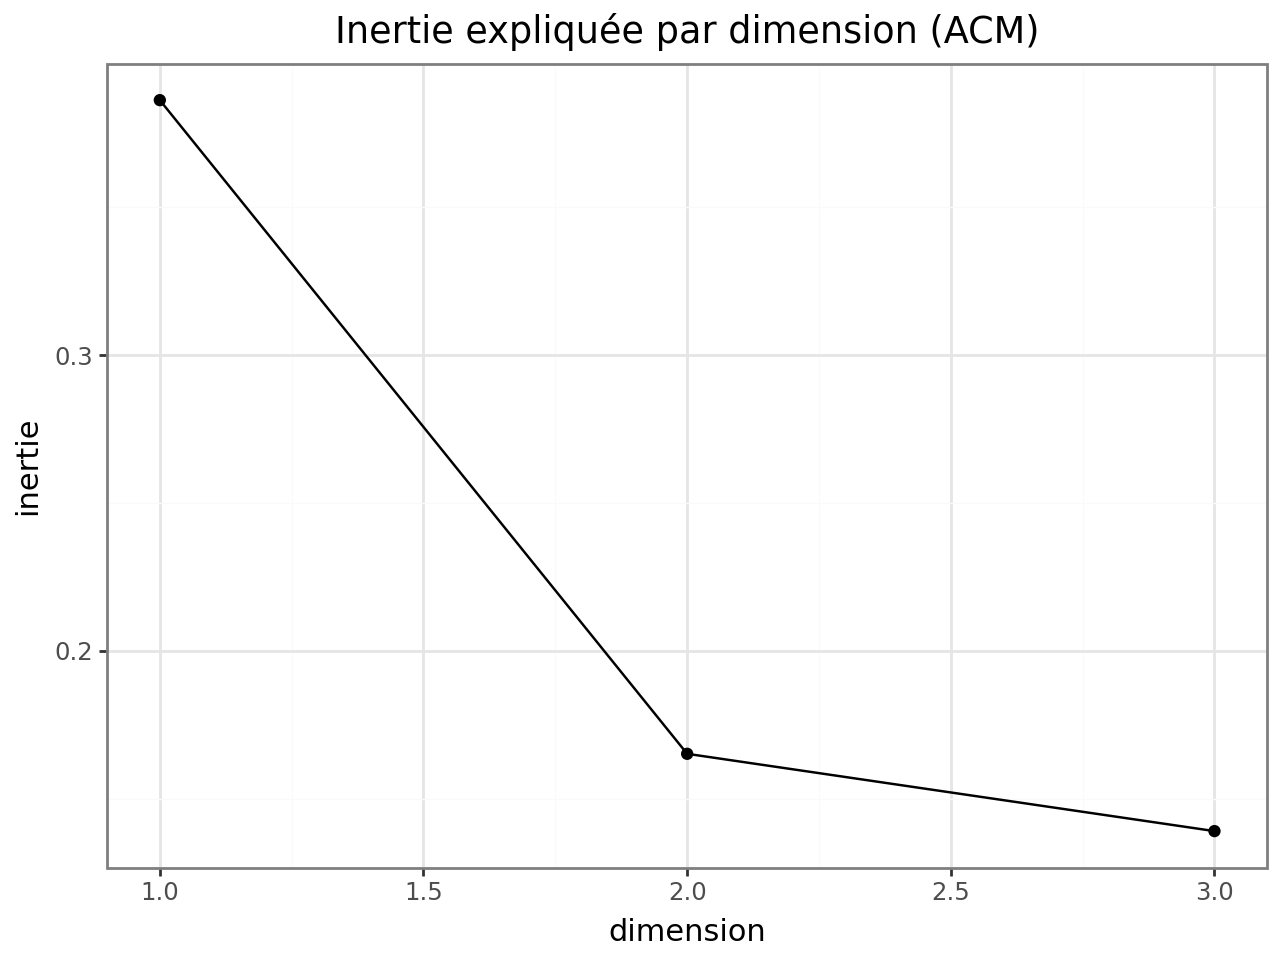

In [19]:
# Inertie expliquée
eig = mca_fit.eigenvalues_
inertia_df = pd.DataFrame({
    "dimension": range(1, len(eig) + 1),
    "inertie": eig,
    "inertie_cumulee": np.cumsum(eig)
})

p_inertia = (
    ggplot(inertia_df, aes(x="dimension", y="inertie")) +
    geom_line() + geom_point() +
    theme_bw() +
    labs(title="Inertie expliquée par dimension (ACM)")
)

p_inertia

In [20]:
contrib = mca.column_contributions_

contrib_12 = contrib.iloc[:, :2]
contrib_12.columns = ["Dim1", "Dim2"]

print("\nTop contributions – Dimension 1")
print(contrib_12["Dim1"].sort_values(ascending=False).head(15))

print("\nTop contributions – Dimension 2")
print(contrib_12["Dim2"].sort_values(ascending=False).head(15))


Top contributions – Dimension 1
conso_demat_films_bin__Non      0.094082
conso_demat_series_bin__Non     0.081971
conso_demat_mus_bin__Non        0.077907
conso_demat_jv_bin__Non         0.061512
conso_demat_photos_bin__Non     0.058292
conso_demat_logi_bin__Non       0.043049
conso_demat_livres_bin__Non     0.039464
conso_demat_presse_bin__Non     0.035932
conso_demat_retrans_bin__Non    0.031569
conso_demat_logi_bin__Oui       0.029867
conso_demat_jv_bin__Oui         0.029701
conso_demat_series_bin__Oui     0.028663
conso_demat_films_bin__Oui      0.028106
conso_demat_retrans_bin__Oui    0.027562
freq_demat_mus__Intensif        0.025736
Name: Dim1, dtype: float64

Top contributions – Dimension 2
freq_demat_films__Intensif       0.089902
freq_demat_jv__Intensif          0.069865
freq_demat_series__Intensif      0.066470
conso_demat_presse_bin__Oui      0.046292
freq_demat_livres__Intensif      0.041146
freq_demat_retrans__Intensif     0.040123
freq_demat_films__Occasionnel    0.03879

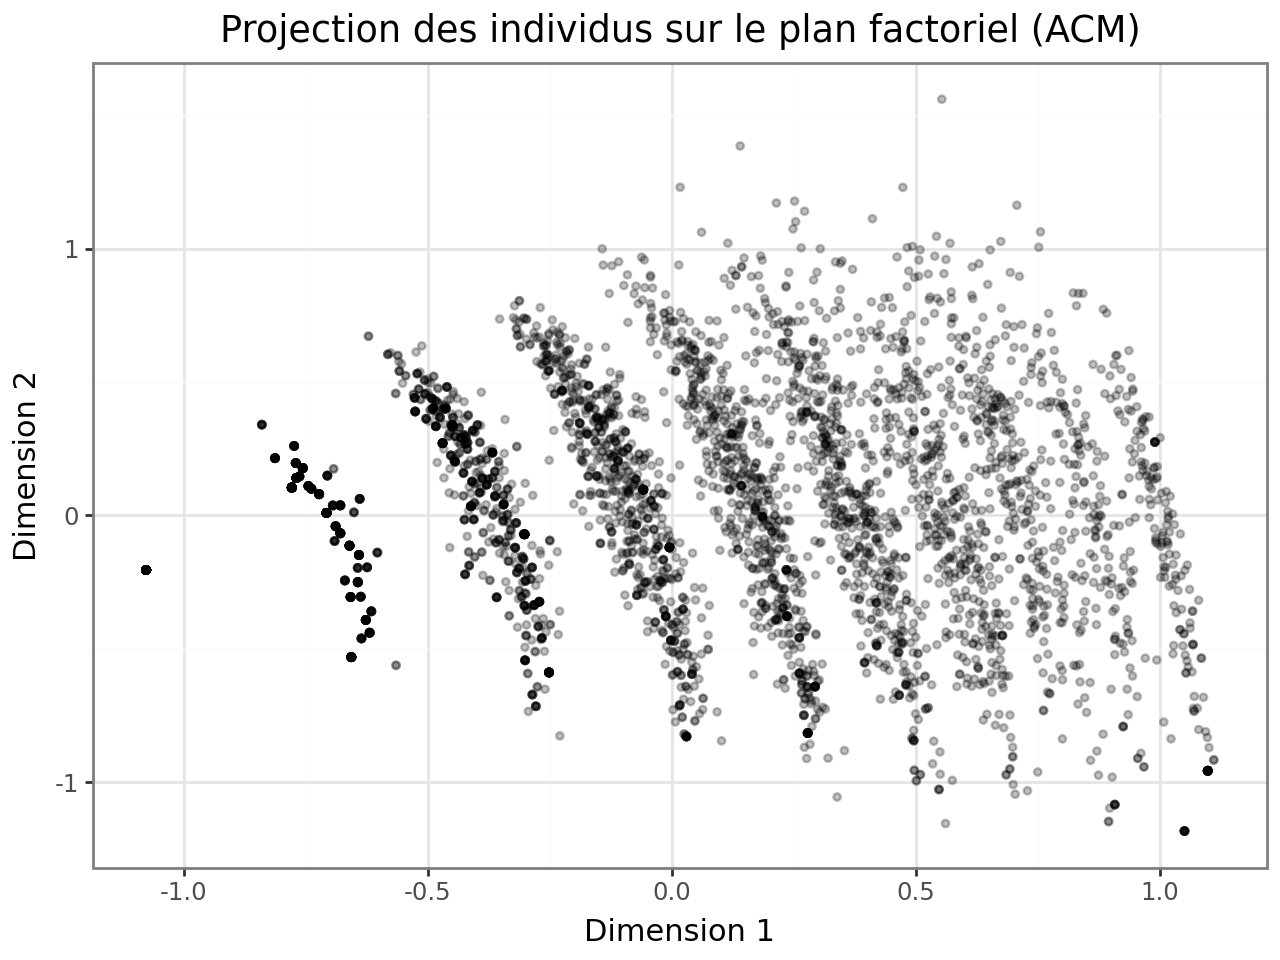

In [21]:
# Coordonnées individuelles
coords = mca_fit.transform(df_barometre_recode[acm_vars])

ind = coords.iloc[:, :2].copy()
ind.columns = ["Dim1", "Dim2"]


p_ind = (
    ggplot(ind, aes(x="Dim1", y="Dim2")) +
    geom_point(alpha=0.25, size=1) +
    theme_bw() +
    labs(
        title="Projection des individus sur le plan factoriel (ACM)",
        x="Dimension 1",
        y="Dimension 2"
    )
)

p_ind


3 clusters
2    0.42
1    0.31
0    0.26
Name: proportion, dtype: float64

4 clusters
1    0.31
2    0.29
0    0.21
3    0.19
Name: proportion, dtype: float64

5 clusters
2    0.29
1    0.23
4    0.18
3    0.17
0    0.13
Name: proportion, dtype: float64
   k      inertia
0  2  1274.851336
1  3   834.014611
2  4   612.346485
3  5   483.631963
4  6   422.640646
5  7   357.984342
6  8   299.901520


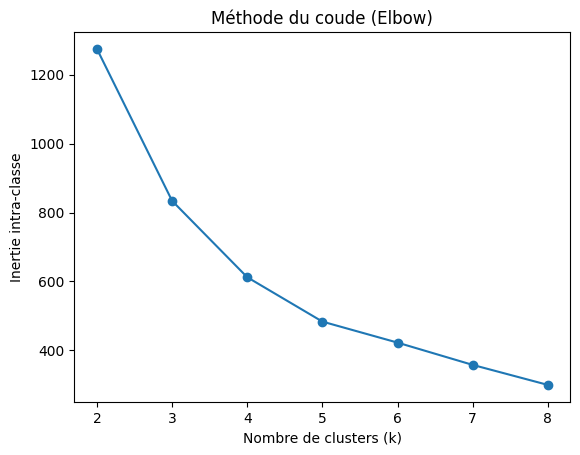

In [22]:
X = coords.iloc[:, :2]  # Dim 1 et Dim 2 uniquement

inertia = []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    inertia.append(km.inertia_)
    if k in [3,4,5]:
        labels = km.fit_predict(X)
        print(f"\n{k} clusters")
        print(pd.Series(labels).value_counts(normalize=True).round(2))


elbow_df = pd.DataFrame({"k": K, "inertia": inertia})
print(elbow_df)


plt.figure()
plt.plot(elbow_df["k"], elbow_df["inertia"], marker="o")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-classe")
plt.title("Méthode du coude (Elbow)")
plt.show()

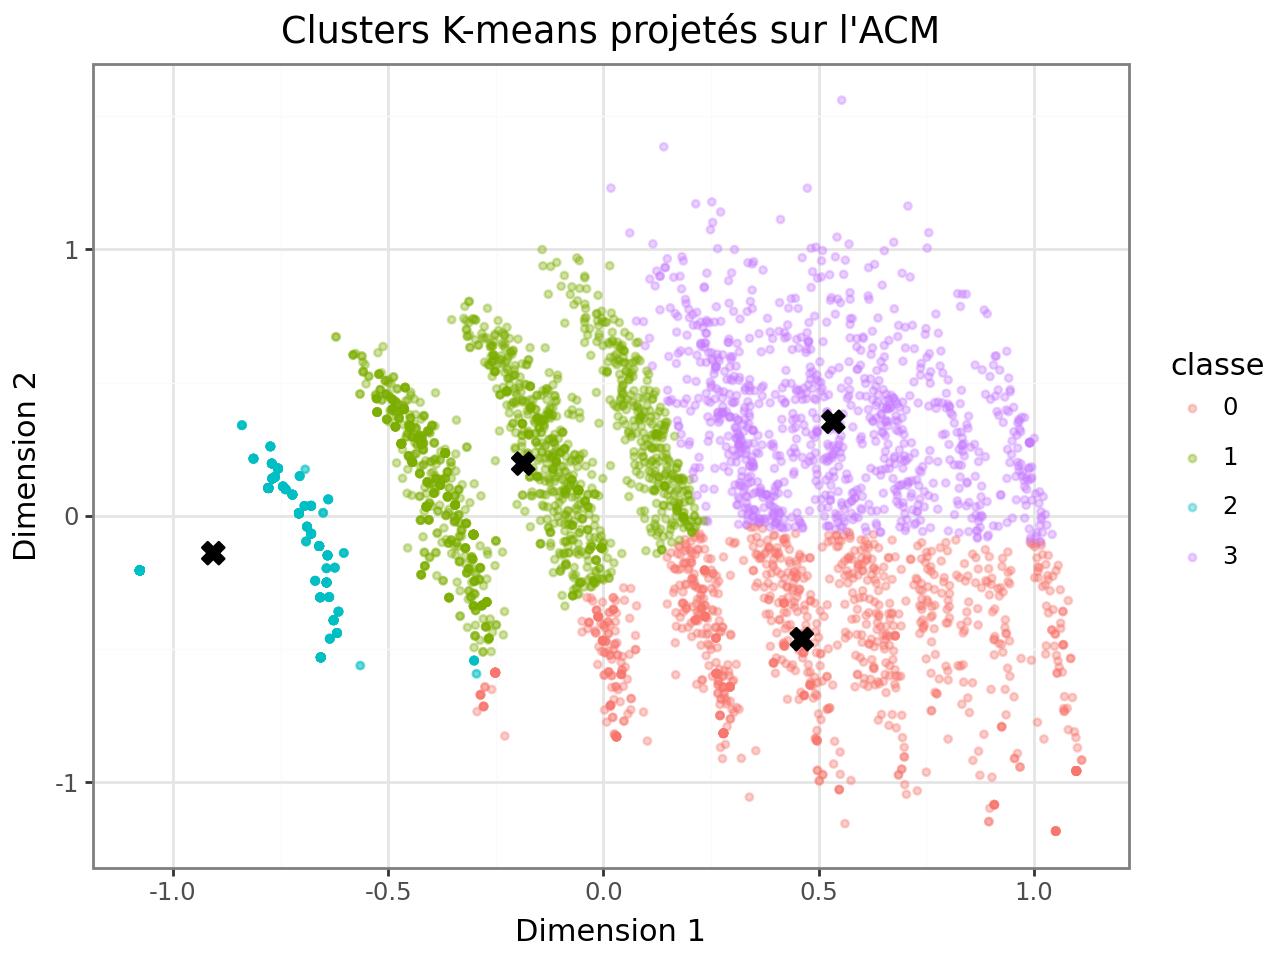

In [23]:
X = coords.iloc[:, :2].copy()
X.columns = ["Dim_1", "Dim_2"]

kmeans = KMeans(n_clusters=4, random_state=42)
df_barometre_recode["classe"] = kmeans.fit_predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids["classe"] = centroids.index.astype("category")

plot_df = X.copy()
plot_df["classe"] = df_barometre_recode["classe"].astype("category")

p = (
    ggplot(plot_df, aes("Dim_1", "Dim_2", color="classe")) +
    geom_point(alpha=0.35, size=1) +
    geom_point(data=centroids, mapping=aes("Dim_1", "Dim_2"),
               color="black", size=4, shape="X") +
    theme_bw() +
    labs(title="Clusters K-means projetés sur l'ACM",
         x="Dimension 1", y="Dimension 2")
)

p

## Consommations et légalité

Variables actives ACM : ['freq_demat_mus', 'freq_demat_films', 'freq_demat_series', 'freq_demat_photos', 'freq_demat_jv', 'freq_demat_livres', 'freq_demat_logi', 'freq_demat_presse', 'freq_demat_retrans', 'conso_demat_mus_bin', 'conso_demat_films_bin', 'conso_demat_series_bin', 'conso_demat_photos_bin', 'conso_demat_jv_bin', 'conso_demat_livres_bin', 'conso_demat_logi_bin', 'conso_demat_presse_bin', 'conso_demat_retrans_bin', 'conso_legale', 'conso_illegale', 'conso_legale_et_illegale']
  freq_demat_mus freq_demat_films freq_demat_series freq_demat_photos  \
0            NaN              NaN               NaN               NaN   
1            NaN              NaN               NaN          Regulier   
2       Intensif         Intensif          Intensif          Regulier   
3            NaN              NaN               NaN               NaN   
4       Intensif      Occasionnel       Occasionnel               NaN   

  freq_demat_jv freq_demat_livres freq_demat_logi freq_demat_presse  

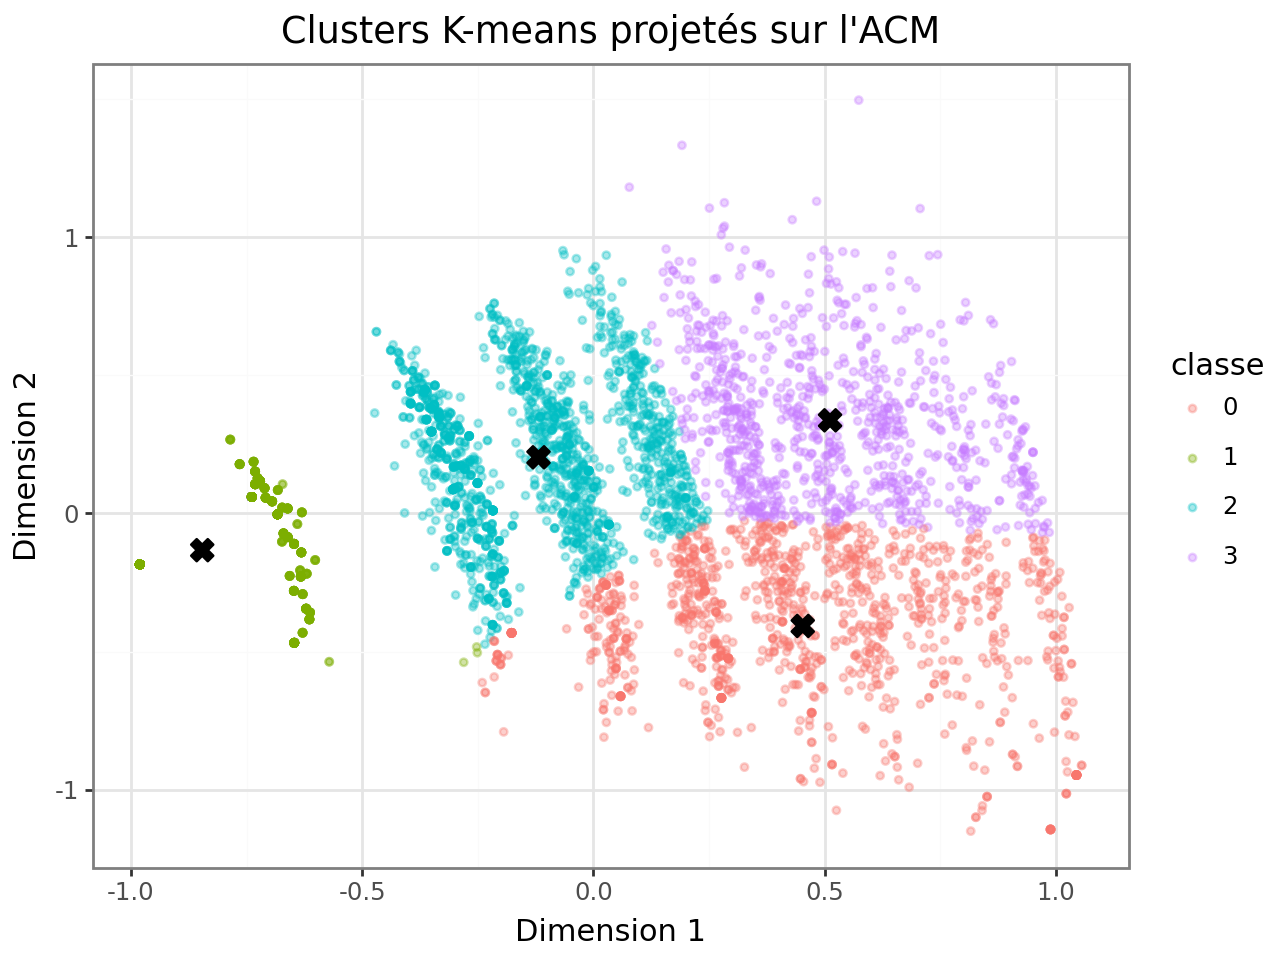

In [24]:
pratiques = [
    "conso_demat_mus", "conso_demat_films", "conso_demat_series",
    "conso_demat_photos", "conso_demat_jv", "conso_demat_livres",
    "conso_demat_logi", "conso_demat_presse", "conso_demat_retrans"
]

for col in pratiques:
    df_barometre_recode[col + "_bin"] = np.where(df_barometre_recode[col].notna() & (df_barometre_recode[col] != 0), "Oui", "Non")


# Variables de pratiques uniquement
acm_vars_csp = [c for c in df_barometre_recode.columns if c.endswith("_bin") or c.startswith("freq_")] + ["conso_legale", "conso_illegale", "conso_legale_et_illegale" ]
print("Variables actives ACM :", acm_vars_csp)
print(df_barometre_recode[acm_vars_csp].head())

mca_csp = MCA(n_components=3,random_state=42)

mca_fit_csp = mca_csp.fit(df_barometre_recode[acm_vars_csp])


# Inertie expliquée
eig_csp = mca_fit_csp.eigenvalues_
inertia_df_csp = pd.DataFrame({
    "dimension": range(1, len(eig_csp) + 1),
    "inertie": eig_csp,
    "inertie_cumulee": np.cumsum(eig_csp)
})

p_inertie_csp = (
    ggplot(inertia_df_csp, aes(x="dimension", y="inertie")) +
    geom_line() + geom_point() +
    theme_bw() +
    labs(title="Inertie expliquée par dimension (ACM)")
)

p_inertie_csp

contrib_csp = mca_csp.column_contributions_

contrib_12_csp = contrib_csp.iloc[:, :2]
contrib_12_csp.columns = ["Dim1", "Dim2"]

print("\nTop contributions – Dimension 1")
print(contrib_12_csp["Dim1"].sort_values(ascending=False).head(15))

print("\nTop contributions – Dimension 2")
print(contrib_12_csp["Dim2"].sort_values(ascending=False).head(15))

# Coordonnées individuelles
coords_csp = mca_fit_csp.transform(df_barometre_recode[acm_vars_csp])

ind_csp = coords_csp.iloc[:, :2].copy()
ind_csp.columns = ["Dim1", "Dim2"]


p_ind_csp = (
    ggplot(ind_csp, aes(x="Dim1", y="Dim2")) +
    geom_point(alpha=0.25, size=1) +
    theme_bw() +
    labs(
        title="Projection des individus sur le plan factoriel (ACM)",
        x="Dimension 1",
        y="Dimension 2"
    )
)

p_ind_csp


X = coords_csp.iloc[:, :2].copy()
X.columns = ["Dim_1", "Dim_2"]

kmeans = KMeans(n_clusters=4, random_state=42)
df_barometre_recode["classe"] = kmeans.fit_predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids["classe"] = centroids.index.astype("category")

plot_df = X.copy()
plot_df["classe"] = df_barometre_recode["classe"].astype("category")

p_csp = (
    ggplot(plot_df, aes("Dim_1", "Dim_2", color="classe")) +
    geom_point(alpha=0.35, size=1) +
    geom_point(data=centroids, mapping=aes("Dim_1", "Dim_2"),
               color="black", size=4, shape="X") +
    theme_bw() +
    labs(title="Clusters K-means projetés sur l'ACM",
         x="Dimension 1", y="Dimension 2")
)

p_csp

### ACM et CLUSTERING sur pratiques d'écoutes

In [25]:

acm_vars_musique = (
    [col for col in df_musique_recode.columns if col in genres]
    + [col for col in df_musique_recode.columns if col.startswith("concerts_")]
)

print("Variables ACM :", acm_vars_musique)
print(df_musique_recode[acm_vars_musique].head())

# 2. Créer et ajuster la MCA
mca = MCA(n_components=3, random_state=42)
mca_fit_musique = mca.fit(df_musique_recode[acm_vars_musique])

# 3. Récupérer les coordonnées des individus et des modalités
coord_individus = mca_fit_musique.row_coordinates(df_musique_recode[acm_vars_musique])
coord_modalites = mca_fit_musique.column_coordinates(df_musique_recode[acm_vars_musique])



Variables ACM : ['var_fr', 'poprock', 'rap', 'classique', 'jazz', 'dance', 'electro', 'metal', 'rnb', 'soul', 'reggae', 'musique_monde', 'concerts_souvent', 'concerts_occasionnel', 'concerts_jamais']
   var_fr  poprock  rap  classique  jazz  dance  electro  metal  rnb  soul  \
0       1        0    0          0     1      0        0      0    0     1   
1       0        1    0          0     1      0        0      0    0     0   
2       1        1    1          0     0      0        0      0    1     0   
3       1        0    0          1     0      0        0      0    0     0   
4       1        0    0          0     1      0        0      0    0     0   

   reggae  musique_monde  concerts_souvent  concerts_occasionnel  \
0       0              0                 0                     0   
1       0              1                 1                     0   
2       0              0                 0                     1   
3       0              0                 0                 

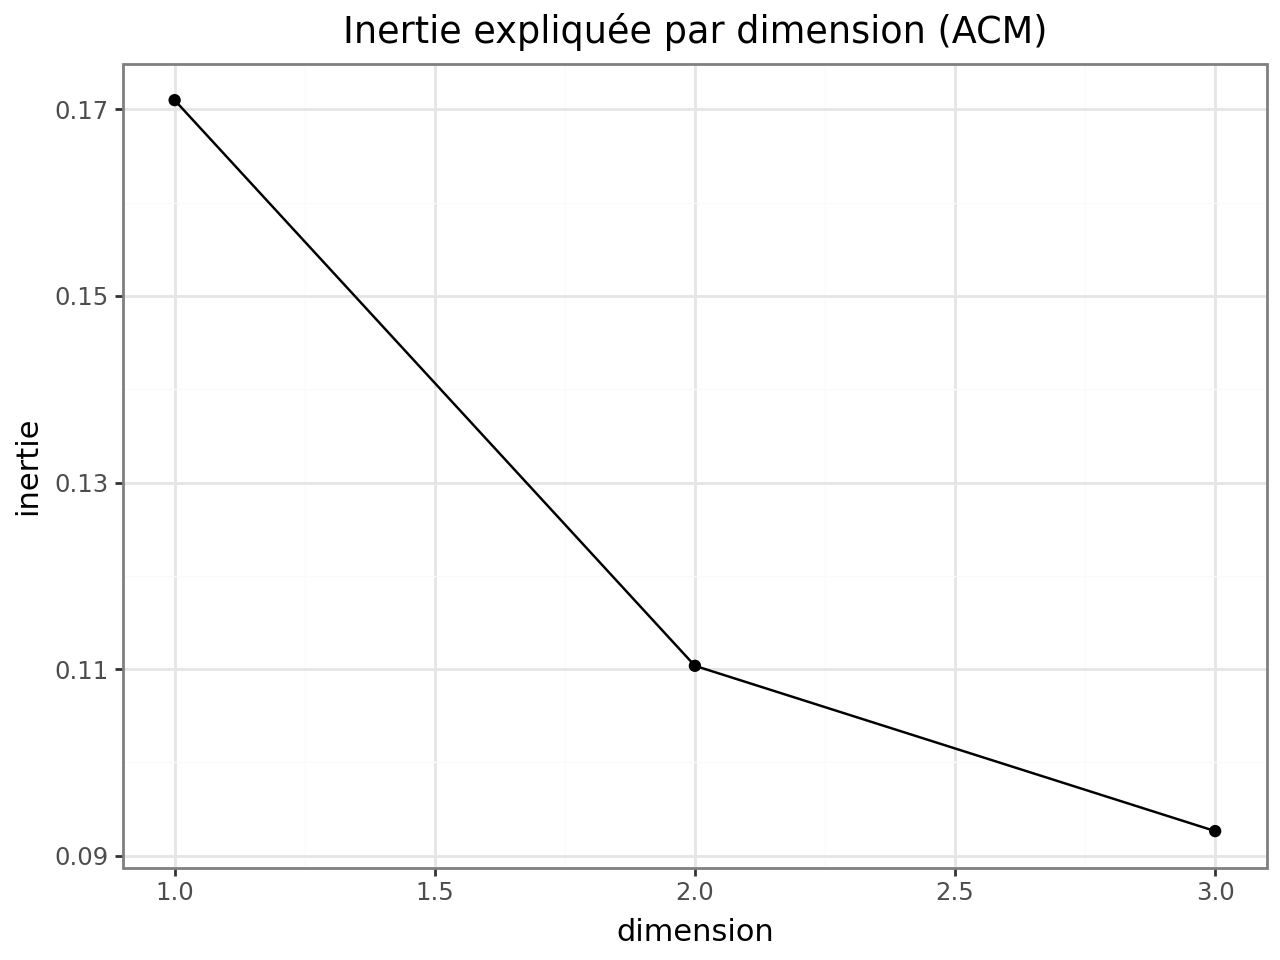

In [26]:
# Inertie expliquée
eig_musique = mca_fit_musique.eigenvalues_
inertia_df_musique = pd.DataFrame({
    "dimension": range(1, len(eig_musique) + 1),
    "inertie": eig_musique,
    "inertie_cumulee": np.cumsum(eig_musique)
})

p_inertie_musique = (
    ggplot(inertia_df_musique, aes(x="dimension", y="inertie")) +
    geom_line() + geom_point() +
    theme_bw() +
    labs(title="Inertie expliquée par dimension (ACM)")
)

p_inertie_musique

In [27]:
contrib_musique = mca.column_contributions_

contrib_12 = contrib_musique.iloc[:, :2]
contrib_12.columns = ["Dim1", "Dim2"]

print("\nTop contributions – Dimension 1")
print(contrib_12["Dim1"].sort_values(ascending=False).head(15))

print("\nTop contributions – Dimension 2")
print(contrib_12["Dim2"].sort_values(ascending=False).head(15))


Top contributions – Dimension 1
soul__1             0.123271
reggae__1           0.106151
dance__1            0.075987
rnb__1              0.070211
musique_monde__1    0.069855
electro__1          0.066539
jazz__1             0.056278
rap__1              0.044306
poprock__0          0.038323
poprock__1          0.037838
metal__1            0.029602
classique__1        0.028836
soul__0             0.025248
rnb__0              0.025020
dance__0            0.023225
Name: Dim1, dtype: float64

Top contributions – Dimension 2
classique__1           0.180311
rap__1                 0.173333
rnb__1                 0.140155
jazz__1                0.133166
rap__0                 0.058762
classique__0           0.054552
rnb__0                 0.049944
musique_monde__1       0.041959
dance__1               0.040026
jazz__0                0.027892
metal__1               0.013381
musique_monde__0       0.013316
dance__0               0.012234
concerts_souvent__1    0.010803
electro__1             0

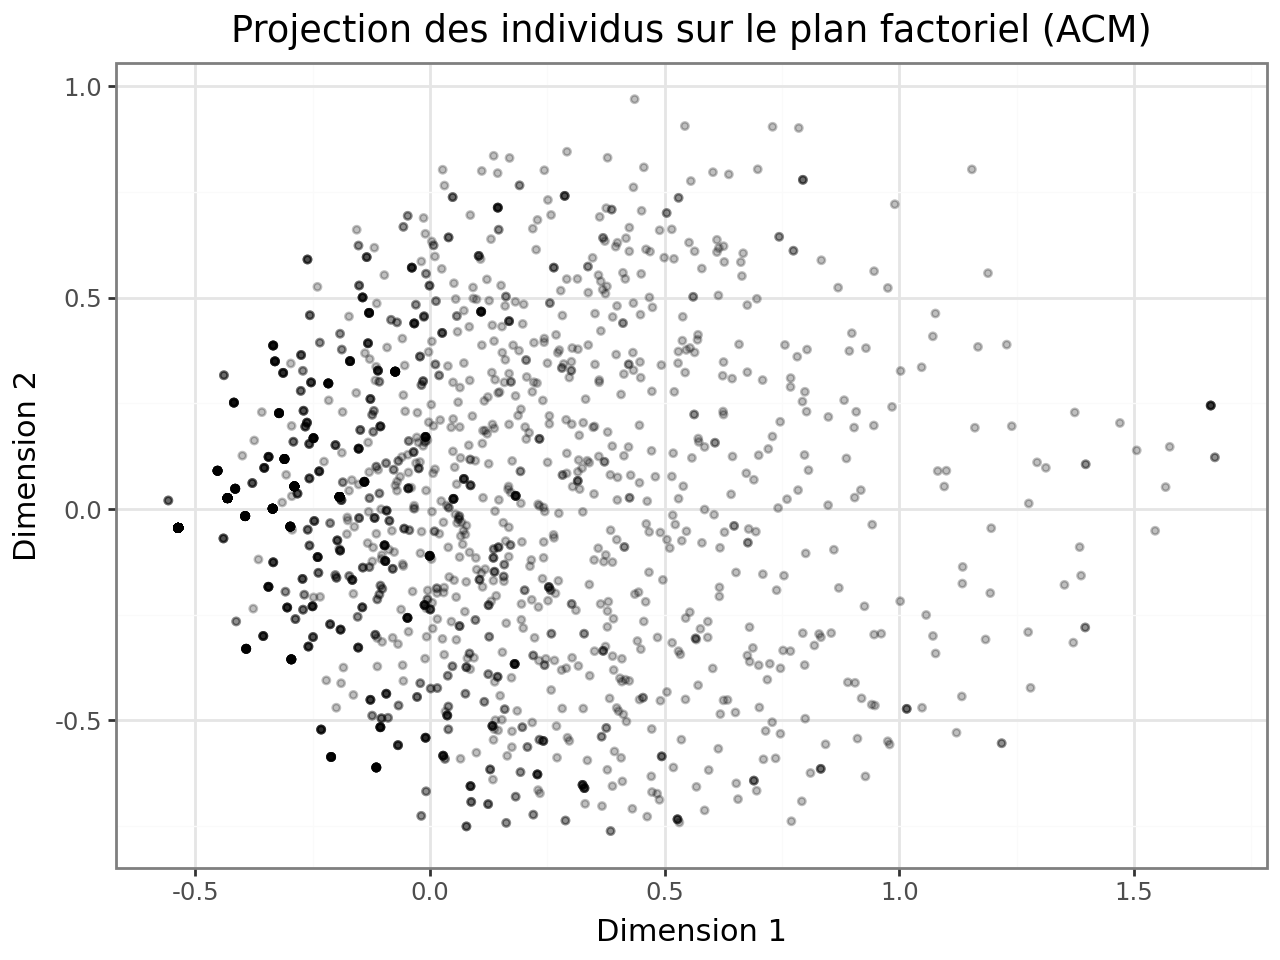

In [28]:
# Coordonnées individuelles
coords = mca_fit_musique.transform(df_musique_recode[acm_vars_musique])

ind = coords.iloc[:, :2].copy()
ind.columns = ["Dim1", "Dim2"]


p_ind = (
    ggplot(ind, aes(x="Dim1", y="Dim2")) +
    geom_point(alpha=0.25, size=1) +
    theme_bw() +
    labs(
        title="Projection des individus sur le plan factoriel (ACM)",
        x="Dimension 1",
        y="Dimension 2"
    )
)

p_ind